<a href="https://colab.research.google.com/github/The-cheater/dogs-cats/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [8]:
# Load flower dataset instead (works without issues)
(train_data, val_data), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = info.features['label'].num_classes
print("Number of classes:", NUM_CLASSES)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.EDPJEP_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of classes: 5


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

train_batches = train_data.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_batches = val_data.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)

Epoch 1/10
35/92 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - accuracy: 0.2660 - loss: 2.1626

KeyboardInterrupt: 

In [15]:
#transfer learning in it


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # We'll add our own top layers
    weights='imagenet'  # Pre-trained on ImageNet
)
base_model.trainable = False  # Freeze base model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5  # Transfer learning needs fewer epochs
)


Epoch 1/5
66/92 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5816 - loss: 1.1134

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning: Accuracy vs Epochs')
plt.legend()
plt.show()


In [ ]:
val_loss, val_acc = model.evaluate(val_batches)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


In [ ]:
model.save("flower_transfer_learning_model.h5")


In [ ]:
#fine tuning it

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load tf_flowers dataset
(train_data, val_data), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = info.features['label'].num_classes
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_batches = train_data.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_batches = val_data.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [20]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the whole base model for now


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7da7ff694400>
Traceback (most recent call last):
  File "/usr/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


In [21]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Warm-up training (base_model frozen)
model.fit(train_batches, validation_data=val_batches, epochs=3)


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6742 - loss: 0.8642 - val_accuracy: 0.8787 - val_loss: 0.3401
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8818 - loss: 0.3194 - val_accuracy: 0.9046 - val_loss: 0.2927
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9158 - loss: 0.2400 - val_accuracy: 0.9033 - val_loss: 0.2984


In [23]:
# Unfreeze from a certain layer onwards (e.g., last 30 layers)
base_model.trainable = True

# Freeze earlier layers to avoid overfitting and faster training
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [25]:
fine_tune_epochs = 5  # Can increase to 10–15 for better accuracy

history_fine = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=fine_tune_epochs
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.6982 - loss: 0.7928 - val_accuracy: 0.8883 - val_loss: 0.3350
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8764 - loss: 0.3518 - val_accuracy: 0.8937 - val_loss: 0.3223
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8968 - loss: 0.3018 - val_accuracy: 0.9046 - val_loss: 0.2959
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9208 - loss: 0.2377 - val_accuracy: 0.9060 - val_loss: 0.2738
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9356 - loss: 0.2009 - val_accuracy: 0.9142 - val_loss: 0.2591


In [26]:
loss, acc = model.evaluate(val_batches)
print(f"Fine-tuned model accuracy: {acc * 100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9107 - loss: 0.2756
Fine-tuned model accuracy: 91.42%


In [27]:
model.save("fine_tuned_flower_model.h5")


In [29]:
from google.colab import files
uploaded = files.upload()


Saving Screenshot 2025-05-19 172220.png to Screenshot 2025-05-19 172220.png


In [30]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('fine_tuned_flower_model.h5')


In [34]:
# Upload image to test
uploaded = files.upload()



Saving Screenshot 2025-05-19 172400.png to Screenshot 2025-05-19 172400.png


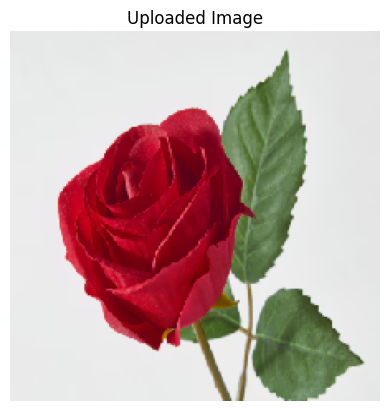

In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Set image path from uploaded file
image_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array = img_array / 255.0  # Normalize

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()


In [36]:
# Predict
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()

# Flower class labels (from tf_flowers dataset)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Show result
print("Predicted class:", class_names[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted class: tulips
